In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '선케어'만 빼서 df생성
item = '선케어'
grouped_by = 'date'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

In [5]:
# MAD적용
lv_day_w['outlier'] = pd.DataFrame(mad_based_outlier(lv_day_w['qty']))
lv_day_w = lv_day_w.loc[lv_day_w.outlier==False]

In [6]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [7]:
train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = lv_day_w.loc[:,list_col]
target = lv_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


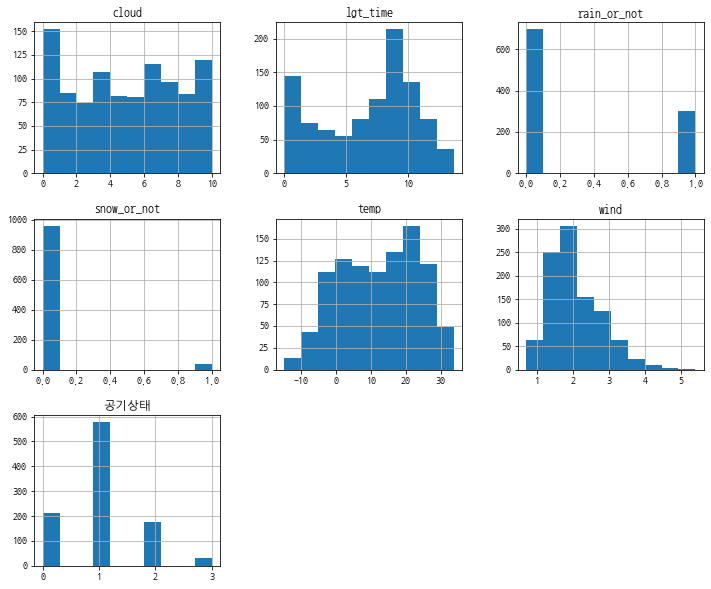

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

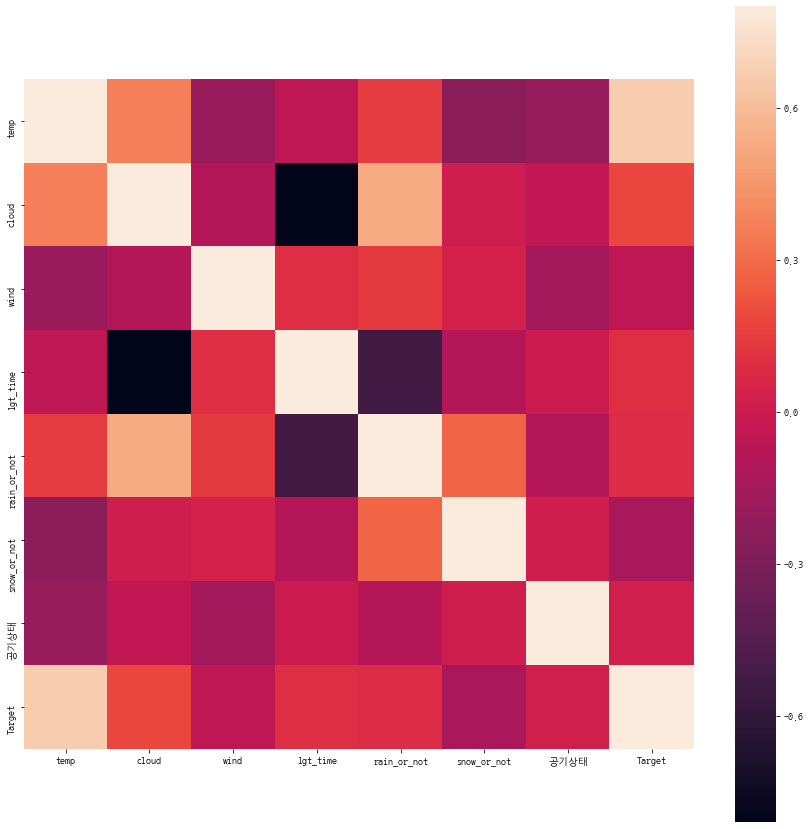

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [13]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)
combined.head(1)

,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2
0,1.2,7.0,1.6,2.1,0,0,0,0,1


In [14]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [15]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [16]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0719 18:55:14.241524  2312 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 18:55:14.264463  2312 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 18:55:14.268451  2312 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0719 18:55:14.361203  2312 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat04-vf05.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [22]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0719 17:13:45.174556  9512 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0719 17:13:45.293253  9512 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 547us/step - loss: 3188.2715 - mean_absolute_error: 3188.2715 - val_loss: 1266.7955 - val_mean_absolute_error: 1266.7955

Epoch 00001: val_loss improved from inf to 1266.79545, saving model to 선케어선케어-Weights-001--1266.79545-cat04-vf05.hdf5
Epoch 2/500
585/585 [==============================] - 0s 84us/step - loss: 2545.4938 - mean_absolute_error: 2545.4938 - val_loss: 584.3408 - val_mean_absolute_error: 584.3408

Epoch 00002: val_loss improved from 1266.79545 to 584.34081, saving model to 선케어선케어-Weights-002--584.34081-cat04-vf05.hdf5
Epoch 3/500
585/585 [==============================] - 0s 81us/step - loss: 1435.8066 - mean_absolute_error: 1435.8066 - val_loss: 602.9346 - val_mean_absolute_error: 602.9346

Epoch 00003: val_loss did not improve from 584.34081
Epoch 4/500
585/585 [==============================] - 0s 80us/step - loss: 1339.0637 - mean_absolute_error: 1339.0637 - val_l


Epoch 00035: val_loss did not improve from 584.34081
Epoch 36/500
585/585 [==============================] - 0s 89us/step - loss: 1173.5899 - mean_absolute_error: 1173.5899 - val_loss: 714.1026 - val_mean_absolute_error: 714.1026

Epoch 00036: val_loss did not improve from 584.34081
Epoch 37/500
585/585 [==============================] - 0s 106us/step - loss: 1168.8317 - mean_absolute_error: 1168.8317 - val_loss: 635.8657 - val_mean_absolute_error: 635.8657

Epoch 00037: val_loss did not improve from 584.34081
Epoch 38/500
585/585 [==============================] - 0s 89us/step - loss: 1146.2284 - mean_absolute_error: 1146.2284 - val_loss: 700.9144 - val_mean_absolute_error: 700.9144

Epoch 00038: val_loss did not improve from 584.34081
Epoch 39/500
585/585 [==============================] - 0s 84us/step - loss: 1151.1325 - mean_absolute_error: 1151.1325 - val_loss: 688.5490 - val_mean_absolute_error: 688.5490

Epoch 00039: val_loss did not improve from 584.34081
Epoch 40/500
585/585 

585/585 [==============================] - 0s 102us/step - loss: 1066.6575 - mean_absolute_error: 1066.6575 - val_loss: 633.5010 - val_mean_absolute_error: 633.5010

Epoch 00106: val_loss did not improve from 584.34081
Epoch 107/500
585/585 [==============================] - 0s 123us/step - loss: 1061.4268 - mean_absolute_error: 1061.4268 - val_loss: 646.0449 - val_mean_absolute_error: 646.0449

Epoch 00107: val_loss did not improve from 584.34081
Epoch 108/500
585/585 [==============================] - 0s 124us/step - loss: 1063.9023 - mean_absolute_error: 1063.9023 - val_loss: 654.2757 - val_mean_absolute_error: 654.2757

Epoch 00108: val_loss did not improve from 584.34081
Epoch 109/500
585/585 [==============================] - 0s 128us/step - loss: 1059.6670 - mean_absolute_error: 1059.6670 - val_loss: 643.0155 - val_mean_absolute_error: 643.0155

Epoch 00109: val_loss did not improve from 584.34081
Epoch 110/500
585/585 [==============================] - 0s 109us/step - loss: 105

585/585 [==============================] - 0s 153us/step - loss: 987.9050 - mean_absolute_error: 987.9050 - val_loss: 585.0462 - val_mean_absolute_error: 585.0462

Epoch 00176: val_loss did not improve from 576.48149
Epoch 177/500
585/585 [==============================] - 0s 131us/step - loss: 990.4200 - mean_absolute_error: 990.4200 - val_loss: 614.4591 - val_mean_absolute_error: 614.4591

Epoch 00177: val_loss did not improve from 576.48149
Epoch 178/500
585/585 [==============================] - 0s 140us/step - loss: 982.1079 - mean_absolute_error: 982.1079 - val_loss: 658.5462 - val_mean_absolute_error: 658.5462

Epoch 00178: val_loss did not improve from 576.48149
Epoch 179/500
585/585 [==============================] - 0s 138us/step - loss: 987.9389 - mean_absolute_error: 987.9389 - val_loss: 655.0901 - val_mean_absolute_error: 655.0901

Epoch 00179: val_loss did not improve from 576.48149
Epoch 180/500
585/585 [==============================] - 0s 145us/step - loss: 986.7169 - 

585/585 [==============================] - 0s 142us/step - loss: 964.8495 - mean_absolute_error: 964.8495 - val_loss: 603.8106 - val_mean_absolute_error: 603.8106

Epoch 00211: val_loss did not improve from 552.78638
Epoch 212/500
585/585 [==============================] - 0s 142us/step - loss: 959.1411 - mean_absolute_error: 959.1411 - val_loss: 651.7606 - val_mean_absolute_error: 651.7606

Epoch 00212: val_loss did not improve from 552.78638
Epoch 213/500
585/585 [==============================] - 0s 144us/step - loss: 941.1961 - mean_absolute_error: 941.1961 - val_loss: 649.5688 - val_mean_absolute_error: 649.5688

Epoch 00213: val_loss did not improve from 552.78638
Epoch 214/500
585/585 [==============================] - 0s 143us/step - loss: 964.1692 - mean_absolute_error: 964.1692 - val_loss: 569.5873 - val_mean_absolute_error: 569.5873

Epoch 00214: val_loss did not improve from 552.78638
Epoch 215/500
585/585 [==============================] - 0s 157us/step - loss: 1022.6667 -

Epoch 246/500
585/585 [==============================] - 0s 152us/step - loss: 1016.9333 - mean_absolute_error: 1016.9333 - val_loss: 577.4940 - val_mean_absolute_error: 577.4940

Epoch 00246: val_loss did not improve from 529.65846
Epoch 247/500
585/585 [==============================] - 0s 143us/step - loss: 922.8904 - mean_absolute_error: 922.8904 - val_loss: 625.2184 - val_mean_absolute_error: 625.2184

Epoch 00247: val_loss did not improve from 529.65846
Epoch 248/500
585/585 [==============================] - 0s 157us/step - loss: 908.4491 - mean_absolute_error: 908.4491 - val_loss: 600.4863 - val_mean_absolute_error: 600.4863

Epoch 00248: val_loss did not improve from 529.65846
Epoch 249/500
585/585 [==============================] - 0s 152us/step - loss: 918.4185 - mean_absolute_error: 918.4185 - val_loss: 669.9021 - val_mean_absolute_error: 669.9021

Epoch 00249: val_loss did not improve from 529.65846
Epoch 250/500
585/585 [==============================] - 0s 155us/step - l


Epoch 00316: val_loss did not improve from 529.65846
Epoch 317/500
585/585 [==============================] - 0s 162us/step - loss: 865.0308 - mean_absolute_error: 865.0308 - val_loss: 621.1594 - val_mean_absolute_error: 621.1594

Epoch 00317: val_loss did not improve from 529.65846
Epoch 318/500
585/585 [==============================] - 0s 165us/step - loss: 861.8779 - mean_absolute_error: 861.8779 - val_loss: 673.2414 - val_mean_absolute_error: 673.2414

Epoch 00318: val_loss did not improve from 529.65846
Epoch 319/500
585/585 [==============================] - 0s 177us/step - loss: 861.9900 - mean_absolute_error: 861.9900 - val_loss: 652.8008 - val_mean_absolute_error: 652.8008

Epoch 00319: val_loss did not improve from 529.65846
Epoch 320/500
585/585 [==============================] - 0s 167us/step - loss: 853.8005 - mean_absolute_error: 853.8005 - val_loss: 691.3146 - val_mean_absolute_error: 691.3146

Epoch 00320: val_loss did not improve from 529.65846
Epoch 321/500
585/585 

585/585 [==============================] - 0s 165us/step - loss: 818.7551 - mean_absolute_error: 818.7551 - val_loss: 662.2197 - val_mean_absolute_error: 662.2197

Epoch 00387: val_loss did not improve from 529.65846
Epoch 388/500
585/585 [==============================] - 0s 164us/step - loss: 823.0851 - mean_absolute_error: 823.0851 - val_loss: 618.3859 - val_mean_absolute_error: 618.3859

Epoch 00388: val_loss did not improve from 529.65846
Epoch 389/500
585/585 [==============================] - 0s 176us/step - loss: 830.8199 - mean_absolute_error: 830.8199 - val_loss: 697.0429 - val_mean_absolute_error: 697.0429

Epoch 00389: val_loss did not improve from 529.65846
Epoch 390/500
585/585 [==============================] - 0s 172us/step - loss: 837.5789 - mean_absolute_error: 837.5789 - val_loss: 663.3887 - val_mean_absolute_error: 663.3887

Epoch 00390: val_loss did not improve from 529.65846
Epoch 391/500
585/585 [==============================] - 0s 160us/step - loss: 828.9209 - 

585/585 [==============================] - 0s 172us/step - loss: 803.0860 - mean_absolute_error: 803.0860 - val_loss: 724.9686 - val_mean_absolute_error: 724.9686

Epoch 00422: val_loss did not improve from 529.65846
Epoch 423/500
585/585 [==============================] - 0s 164us/step - loss: 820.0685 - mean_absolute_error: 820.0685 - val_loss: 681.4837 - val_mean_absolute_error: 681.4837

Epoch 00423: val_loss did not improve from 529.65846
Epoch 424/500
585/585 [==============================] - 0s 177us/step - loss: 850.1602 - mean_absolute_error: 850.1602 - val_loss: 634.5008 - val_mean_absolute_error: 634.5008

Epoch 00424: val_loss did not improve from 529.65846
Epoch 425/500
585/585 [==============================] - 0s 155us/step - loss: 810.5108 - mean_absolute_error: 810.5108 - val_loss: 634.9591 - val_mean_absolute_error: 634.9591

Epoch 00425: val_loss did not improve from 529.65846
Epoch 426/500
585/585 [==============================] - 0s 169us/step - loss: 830.0478 - 


Epoch 00492: val_loss did not improve from 529.65846
Epoch 493/500
585/585 [==============================] - 0s 196us/step - loss: 777.9676 - mean_absolute_error: 777.9676 - val_loss: 684.2925 - val_mean_absolute_error: 684.2925

Epoch 00493: val_loss did not improve from 529.65846
Epoch 494/500
585/585 [==============================] - 0s 170us/step - loss: 787.2882 - mean_absolute_error: 787.2882 - val_loss: 708.4961 - val_mean_absolute_error: 708.4961

Epoch 00494: val_loss did not improve from 529.65846
Epoch 495/500
585/585 [==============================] - 0s 228us/step - loss: 767.1831 - mean_absolute_error: 767.1831 - val_loss: 691.1273 - val_mean_absolute_error: 691.1273

Epoch 00495: val_loss did not improve from 529.65846
Epoch 496/500
585/585 [==============================] - 0s 204us/step - loss: 814.5806 - mean_absolute_error: 814.5806 - val_loss: 720.0140 - val_mean_absolute_error: 720.0140

Epoch 00496: val_loss did not improve from 529.65846
Epoch 497/500
585/585 

In [18]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '선케어date-Weights-245--529.65846-cat04-vf05.hdf5'
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

W0719 18:55:17.871878  2312 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0719 18:55:17.872846  2312 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [19]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.920
검증세트점수 : 0.528
XGBoost을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.796
검증세트점수 : 0.522
LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.527
검증세트점수 : 0.466
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.518
검증세트점수 : 0.469
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.527
검증세트점수 : 0.466
OLS을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.527
검증세트점수 : 0.466


In [20]:
# columns_in_data = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not',
#                     '공기상태_0', '공기상태_1', '공기상태_2']

# formulaGen은 단순 1차 다항식을 제조해준다.
# customF = formulaGen(target='qty',ind_features=columns_in_data)
# customF = formulaGen(target='qty',ind_features=['temp', 'wind','lgt_time','rain_or_not'])
customF = 'qty ~ I(temp**2) + cloud + wind + lgt_time + rain_or_not + snow_or_not'

olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )
print(olsModel.summary())

사람이 직접 식을 때려 박았을때 : 0.526
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     143.9
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          6.21e-120
Time:                        18:55:19   Log-Likelihood:                -6387.0
No. Observations:                 732   AIC:                         1.279e+04
Df Residuals:                     725   BIC:                         1.282e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -751.570

In [21]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = lv_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [22]:
# 예측률 계산
# https://yamalab.tistory.com/46

# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌
# 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# MAPE가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.36
RandomForest 모델 MAPE 		: 0.23
XGBoosting  모델 MAPE 		: 0.37
Linear 모델 MAPE 		: 0.59
Ridge 모델 MAPE 		: 0.59
Lasso 모델 MAPE 		: 0.59
OLS 모델 MAPE 			: 0.52


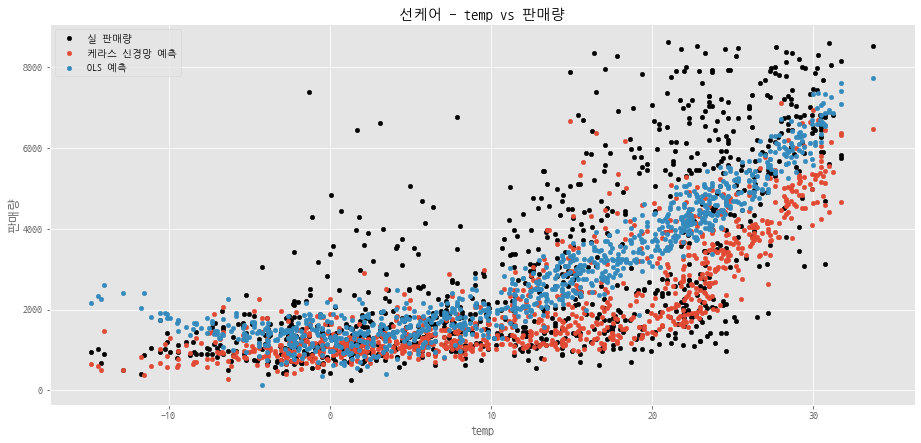

In [23]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2']

# 1~9 : 1 temp ~ 9 공기상태_2
n= 1
# alpha 값 0~1
alp = 1
# scatter plot 점 크기
dot_size = 20

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

## 실험 구간

In [ ]:

# # 2016~2017 : 훈련 / 2018 검증 2:1
# # 1~106 / 106~156
# trainXy = gs_week_w.loc[:cut_line]
# testXy = gs_week_w.loc[cut_line:]
# train_X =pd.DataFrame(trainXy.loc[:,'temp'])
# train_y = trainXy.loc[:,'qty']
# val_X = pd.DataFrame(testXy.loc[:,'temp'])
# val_y = testXy.loc[:,'qty']



# print('여기서 점수란 R-square값을 의미한다.')
# # RandomForest 회귀분석
# RFmodel = RandomForestRegressor()
# RFmodel.fit(train_X,train_y)
# # Get the mean absolute error on the validation data
# RFpredicted = RFmodel.predict(val_X)
# MAE = mean_absolute_error(val_y , RFpredicted)
# print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# # print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# # XGBRegressor 회귀분석
# XGBModel = XGBRegressor(objective='reg:squarederror')
# XGBModel.fit(train_X,train_y , verbose=False)
# # Get the mean absolute error on the validation data :
# XGBpredictions = XGBModel.predict(val_X)
# MAE = mean_absolute_error(val_y , XGBpredictions)
# print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# # print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

# linReg = LinearRegression().fit(train_X, train_y)
# print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

# ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
# print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

# lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
# print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
# print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

# customF = formulaGen(target='qty',ind_features=['temp'])
# olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
# print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

# combined = pd.DataFrame(gs_week_w.loc[:,'temp'])
# target = gs_week_w.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# # predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# result_df = pd.DataFrame()
# result_df['week'] = gs_week_w['week']
# result_df['qty'] = gs_week_w.loc[:,'qty']

# # print("keras 신경망 predictions",predictions.shape)
# # result_df['keras_qty'] = predictions

# # print("randomforest 예상",RFpredicted.shape)
# result_df['rf_qty'] = RFpredicted

# # print("XGBpredictions",XGBpredictions.shape)
# result_df['xgb_qty'] = XGBpredictions

# # print("linearRegression 예상",RFpredicted.shape)
# result_df['lin_qty'] = linPred

# # print("Ridge 예상",RFpredicted.shape)
# result_df['ridge_qty'] = ridPred

# # print("Lasso 예상",RFpredicted.shape)
# result_df['lasso_qty'] = lassoPred

# # print("OLS 예상",RFpredicted.shape)
# result_df['ols_qty'] = olsPred

# ============================================

In [ ]:
# df_graph = result_df.loc[:,['week','qty','keras_qty','rf_qty','xgb_qty','lin_qty','ridge_qty','lasso_qty','ols_qty']]
# for_visual_col = ['week','temp','cloud','wind','lgt_time','snow','rain','PM10']
# df = pd.merge(df_graph, gs_week_w[for_visual_col], on='week', how='left')
# # df.head(1)

In [ ]:
# 2016, 온도
# df_graph = df.loc[df.week <= 53]
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph.temp,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.scatter(df_graph.temp,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.scatter(df_graph.temp,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.scatter(df_graph.temp,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.scatter(df_graph.temp,df_graph.lin_qty, ls='-', label='linear예측')
# plt.scatter(df_graph.temp,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.scatter(df_graph.temp,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.scatter(df_graph.temp,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# qty_columns = list(df_graph.columns)[1:9]
# weather_columns = list(df_graph.columns)[9:]
# print(qty_columns)
# print(weather_columns)

In [ ]:
# x_temp = pd.DataFrame()
# # x_temp['temp'] = list(range(-10,35,1))
# x_temp['temp'] = np.arange(-9,35,0.5)
# combined = x_temp
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.7)
# plt.plot(x_temp, RFpredicted, label = 'rf')
# plt.plot(x_temp, XGBpredictions, label = 'xgb')
# plt.plot(x_temp, linPred, label = 'line')
# plt.plot(x_temp, ridPred, label = 'ridge')
# plt.plot(x_temp, lassoPred, label = 'lasso')
# plt.plot(x_temp, olsPred, label = 'ols')
# plt.plot()
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 실험

In [ ]:
# intercept_lin = linReg.intercept_
# coef_line = linReg.coef_
# # list_col
# linePredict = list()
# x_temp = list(range(-10,38,1))
# for temperature in x_temp:
#     linePredict.append(intercept_lin + coef_line[0]*temperature)

    
# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.3)
# # for q_name in qty_columns:
# #     plt.plot(df_graph[weather_columns[0]],df_graph[q_name], ls='-', label=q_name)
# #     plt.scatter(df_graph.lgt_time,df_graph[q_name], ls='-', label='실제', color='green', alpha=0.5, lw=8)
# #     plt.scatter(df_graph.lgt_time,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# #     plt.scatter(df_graph.lgt_time,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# #     plt.scatter(df_graph.lgt_time,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# #     plt.scatter(df_graph.lgt_time,df_graph.lin_qty, ls='-', label='linear예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.ridge_qty, ls='-', label='ridge예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# #     plt.scatter(df_graph.lgt_time,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.plot(x_temp, linePredict, 'r--', label='linear회귀, 온도만')

# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 시간의 경과에 따른 예측량 비교

In [ ]:
# # 2016
# df_graph = result_df.loc[result_df.week <=53]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# # 2017
# df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2018
# df_graph = result_df.loc[(result_df.week >=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2016~2018
# plt.figure(figsize=(15.5, 10))
# plt.plot(result_df.week,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(result_df.week,result_df.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(result_df.week,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(result_df.week,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# def r2_score(v_true, v_pred):
#     ssr = np.sum(np.square(v_pred - np.mean(v_true)))
#     sst = np.sum(np.square(v_true - np.mean(v_true)))
#     return ( ssr / sst)

In [ ]:
# checked_for = '2016~2017'
# combined = aaaaa.loc[:106,'temp':'PM10']
# target = aaaaa.loc[:106,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)
# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2018'
# combined = aaaaa.loc[106:,'temp':'PM10']
# target = aaaaa.loc[106:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2016~2018'
# combined = aaaaa.loc[:,'temp':'PM10']
# target = aaaaa.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# path = 'D:/project/contest/data/result/'
# result_df.to_csv(path+item+'_'+grouped_by+'_predict(lowVIF07).csv', encoding='utf-8', index=False)